<a href="https://colab.research.google.com/github/ahmadsakir/Kaggle-Notebooks/blob/main/Copy_of_Supplement_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
zahidmughal2343_supplement_sales_data_path = kagglehub.dataset_download('zahidmughal2343/supplement-sales-data')

print('Data source import complete.')


Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet

In [ ]:
df = pd.read_csv('/kaggle/input/supplement-sales-data/Supplement_Sales_Weekly_Expanded.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df.head(10)

,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
Date,,,,,,,,,
2020-01-06,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart
2020-01-06,Electrolyte Powder,Hydration,154,35.92,5531.68,0.04,2,USA,Amazon
2020-01-06,Iron Supplement,Mineral,149,42.97,6402.53,0.22,2,Canada,iHerb
2020-01-06,Green Tea Extract,Fat Burner,143,31.88,4558.84,0.06,3,UK,Walmart
2020-01-06,Biotin,Vitamin,159,28.79,4577.61,0.10,1,UK,iHerb
2020-01-06,Ashwagandha,Herbal,181,15.49,2803.69,0.14,1,USA,Amazon
2020-01-06,Magnesium,Mineral,134,20.76,2781.84,0.00,0,Canada,Amazon
2020-01-06,Collagen Peptides,Protein,147,10.96,1611.12,0.06,2,USA,Amazon
2020-01-06,Melatonin,Sleep Aid,164,34.41,5643.24,0.04,1,USA,Walmart


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4384 entries, 2020-01-06 to 2025-03-31
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Product Name    4384 non-null   object 
 1   Category        4384 non-null   object 
 2   Units Sold      4384 non-null   int64  
 3   Price           4384 non-null   float64
 4   Revenue         4384 non-null   float64
 5   Discount        4384 non-null   float64
 6   Units Returned  4384 non-null   int64  
 7   Location        4384 non-null   object 
 8   Platform        4384 non-null   object 
dtypes: float64(3), int64(2), object(4)
memory usage: 342.5+ KB


In [ ]:
df['Product Name'].unique()

array(['Whey Protein', 'Electrolyte Powder', 'Iron Supplement',
       'Green Tea Extract', 'Biotin', 'Ashwagandha', 'Magnesium',
       'Collagen Peptides', 'Melatonin', 'Creatine', 'BCAA',
       'Pre-Workout', 'Multivitamin', 'Fish Oil', 'Vitamin C', 'Zinc'],
      dtype=object)

In [ ]:
product_names = ["Whey Protein", "Vitamin C", "Fish Oil", "Multivitamin",
                 "Pre-Workout", "BCAA", "Creatine", "Zinc", "Collagen Peptides",
                 "Magnesium", "Ashwagandha", "Melatonin", "Biotin",
                 "Green Tea Extract", "Iron Supplement", "Electrolyte Powder"]

product_dfs = {}  # Dictionary to store the DataFrames

for product_name in product_names:
    # Create a DataFrame for the current product
    product_dfs[product_name] = df[df["Product Name"] == product_name]

In [ ]:
# access products
whey_sales = product_dfs["Whey Protein"]
whey_sales.head()

,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
Date,,,,,,,,,
2020-01-06,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart
2020-01-13,Whey Protein,Protein,150,12.08,1812.00,0.02,2,UK,Amazon
2020-01-20,Whey Protein,Protein,157,41.81,6564.17,0.19,0,USA,Walmart
2020-01-27,Whey Protein,Protein,137,26.73,3662.01,0.01,0,UK,Amazon
2020-02-03,Whey Protein,Protein,165,33.11,5463.15,0.10,2,Canada,iHerb


In [ ]:
products = ["Whey Protein", "Vitamin C", "Fish Oil", "Multivitamin", "Pre-Workout", "BCAA", "Creatine", "Zinc", "Collagen Peptides", "Magnesium", "Ashwagandha", "Melatonin", "Biotin", "Green Tea Extract", "Iron Supplement", "Electrolyte Powder"]

weekly_sales = {}  # Dictionary to store weekly sales for each product

for product in products:
    # Filter data for the current product
    product_sales = df[df["Product Name"] == product]

    # Calculate weekly sales and store in the dictionary
    weekly_sales[product] = product_sales.groupby('Date')['Units Sold'].sum().reset_index()
    weekly_sales[product].columns = ['ds', 'y'] # Rename columns to be compatible with Prophet

In [ ]:
# Accessing weekly sales for a specific product:
whey_weekly = weekly_sales["Whey Protein"]
whey_weekly.head()

,ds,y
0,2020-01-06,143
1,2020-01-13,150
2,2020-01-20,157
3,2020-01-27,137
4,2020-02-03,165


In [ ]:
whey_weekly.columns = ['ds', 'y']
train_size = int(len(whey_weekly) * 0.8)
train_data = whey_weekly[:train_size]
test_data = whey_weekly[train_size:]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      219 non-null    datetime64[ns]
 1   y       219 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.6 KB


In [ ]:
model = Prophet()
model.fit(train_data)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq3xrvbs6/bnfsv2zn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq3xrvbs6/nwu0dyf8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26053', 'data', 'file=/tmp/tmpq3xrvbs6/bnfsv2zn.json', 'init=/tmp/tmpq3xrvbs6/nwu0dyf8.json', 'output', 'file=/tmp/tmpq3xrvbs6/prophet_modelii81xt01/prophet_model-20250515022949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:29:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:29:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=len(test_data), freq='W')
forecast = model.predict(future)

In [ ]:
test_forecast = forecast.iloc[-len(test_data):]
test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
219,2024-03-17,152.934537,137.375478,166.248879,152.934537,152.934537,-1.160383,-1.160383,-1.160383,-1.160383,-1.160383,-1.160383,0.0,0.0,0.0,151.774154
220,2024-03-24,152.957478,138.264965,167.187361,152.957467,152.957488,0.195578,0.195578,0.195578,0.195578,0.195578,0.195578,0.0,0.0,0.0,153.153056
221,2024-03-31,152.980419,141.408729,169.856891,152.980361,152.980490,3.163700,3.163700,3.163700,3.163700,3.163700,3.163700,0.0,0.0,0.0,156.144118
222,2024-04-07,153.003360,141.977130,172.191261,153.003238,153.003509,4.930213,4.930213,4.930213,4.930213,4.930213,4.930213,0.0,0.0,0.0,157.933572
223,2024-04-14,153.026300,140.625445,170.805362,153.026050,153.026545,3.442852,3.442852,3.442852,3.442852,3.442852,3.442852,0.0,0.0,0.0,156.469153


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
# Calculate metrics
mae = mean_absolute_error(test_data["y"], test_forecast["yhat"])
mape = mean_absolute_percentage_error(test_data["y"], test_forecast["yhat"]) * 100

print(f"MAE: {mae:.2f} units")
print(f"MAPE: {mape:.2f}%")

MAE: 9.80 units
MAPE: 6.64%


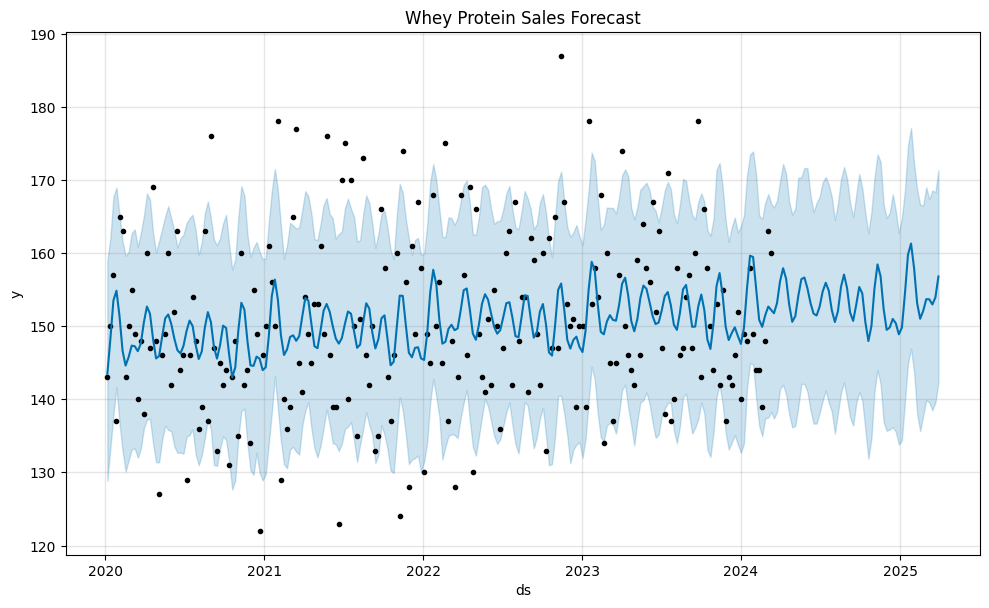

In [ ]:
fig = model.plot(forecast)
plt.title('Whey Protein Sales Forecast')
plt.show()

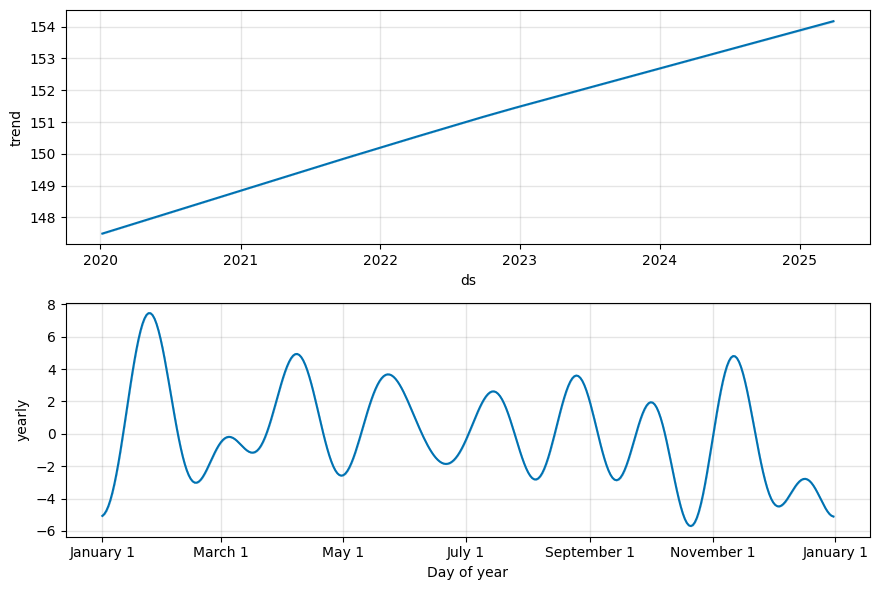

In [ ]:
fig2 = model.plot_components(forecast)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

In [ ]:
plot_plotly(model, forecast)

In [ ]:
plot_components_plotly(model, forecast)

/usr/local/lib/python3.11/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.

